# Imports

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

# Dataset Analysis


In [3]:
data = pd.read_csv('credit_risk_dataset.csv')

# Basic information about the dataset
print("Basic Dataset Information:")
print(data.info())
print("\n")

# First few rows of the dataset
print("First 5 Rows of the Dataset:")
print(data.head())
print("\n")

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())
print("\n")

# Summary statistics for numerical columns
print("Summary Statistics for Numerical Features:")
print(data.describe())
print("\n")

# Summary statistics for categorical columns
print("Summary Statistics for Categorical Features:")
print(data.describe(include=['object']))
print("\n")

# Check the distribution of the target variable
print("Target Variable Distribution (loan_status):")
print(data['loan_status'].value_counts(normalize=True))
print("\n")

# Check for unique values in categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Unique Values in Categorical Features:")
for col in categorical_columns:
    print(f"{col}: {data[col].unique()}")
print("\n")

# Check correlations between numerical columns
print("Correlation Matrix (Numerical Features Only):")
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
print(data[numerical_columns].corr())
print("\n")

# Identify potential outliers using IQR statistical thresholds
print("Potential Outliers (values beyond 1.5*IQR):")
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} potential outliers")
print("\n")

# Check for class imbalance in target variable
print("Class Balance of Target Variable (loan_status):")
print(data['loan_status'].value_counts())
print("\n")

Basic Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

# Hyperparameter Tuning

In [4]:
# Load and preprocess the data (sample only)
def load_and_preprocess_sample(filepath, sample_size=5000):
    """
    Load, preprocess, and sample the dataset for faster hyperparameter tuning.
    """
    # Load full data
    data = pd.read_csv(filepath)

    # Preprocess
    # Impute missing values
    data['person_emp_length'] = data['person_emp_length'].fillna(data['person_emp_length'].median())
    data['loan_int_rate'] = data['loan_int_rate'].fillna(data['loan_int_rate'].mean())

    # Handle outliers using the 1.5*IQR rule
    numerical_cols = ['person_age', 'person_income', 'person_emp_length',
                      'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                      'cb_person_cred_hist_length']
    for col in numerical_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

    # Encode categorical features
    binary_encoder = {'Y': 1, 'N': 0}
    data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(binary_encoder)
    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    # Feature engineering
    data['debt_to_income_ratio'] = data['loan_amnt'] / data['person_income']
    data['employment_to_age_ratio'] = data['person_emp_length'] / data['person_age']
    data['interest_rate_category'] = pd.cut(data['loan_int_rate'], bins=[0, 10, 15, np.inf], labels=['Low', 'Medium', 'High'])
    data = pd.get_dummies(data, columns=['interest_rate_category'], drop_first=True)

    # Sample the dataset
    data_sample = data.sample(n=sample_size, random_state=42)
    return data_sample

# Balance the dataset using SMOTE
def balance_data(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Hyperparameter tuning
def hyperparameter_tuning(X, y):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1]
    }

    # Stratified K-Fold Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)

    # Output the best parameters and score
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best ROC-AUC Score: {grid.best_score_:.4f}")
    return grid.best_params_

# Main function
def main():
    # Load and preprocess the dataset (sample)
    data_filepath = '/content/credit_risk_dataset.csv'
    data_sample = load_and_preprocess_sample(data_filepath, sample_size=5000)

    # Split features and target
    target_column = 'loan_status'
    X = data_sample.drop(target_column, axis=1)
    y = data_sample[target_column]

    # Balance the dataset
    X_balanced, y_balanced = balance_data(X, y)

    # Perform hyperparameter tuning
    best_params = hyperparameter_tuning(X_balanced, y_balanced)

    # Save the best parameters for later use
    print("\nSave these best parameters for the main model:")
    print(best_params)

if __name__ == "__main__":
    main()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}
Best ROC-AUC Score: 0.9821

Save these best parameters for the main model:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


# Main Model



=== Logistic Regression Evaluation ===
Accuracy: 0.8605
Precision: 0.8774
Recall: 0.8383
F1-Score: 0.8574
ROC-AUC: 0.9248

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      5095
           1       0.88      0.84      0.86      5095

    accuracy                           0.86     10190
   macro avg       0.86      0.86      0.86     10190
weighted avg       0.86      0.86      0.86     10190



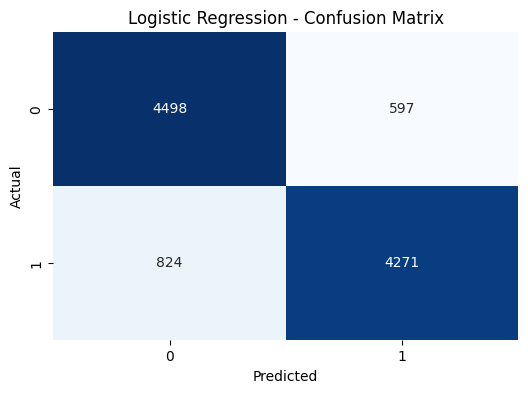


=== XGBoost Evaluation ===
Accuracy: 0.9594
Precision: 0.9889
Recall: 0.9291
F1-Score: 0.9581
ROC-AUC: 0.9881

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.99      0.93      0.96      5095

    accuracy                           0.96     10190
   macro avg       0.96      0.96      0.96     10190
weighted avg       0.96      0.96      0.96     10190



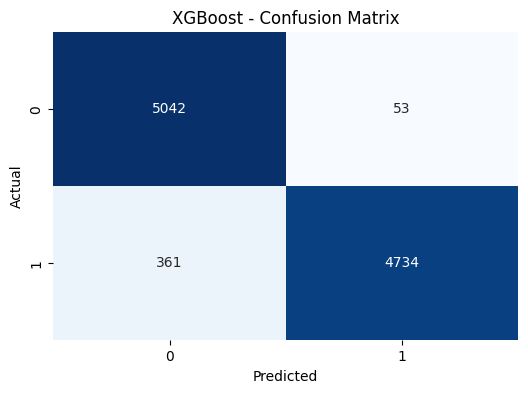


Trained XGBoost model saved as 'loan_default_model.pkl'.

=== Model Performance Comparison ===
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.860550   0.877362  0.838273  0.857372  0.924814
XGBoost              0.959372   0.988928  0.929146  0.958106  0.988098


In [5]:
# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath)

# Impute missing values
def impute_missing_values(df):
    """
    Impute missing values in the DataFrame as follows:
    - person_emp_length: median
    - loan_int_rate: mean
    """
    median_imputer = SimpleImputer(strategy='median')
    mean_imputer = SimpleImputer(strategy='mean')

    df['person_emp_length'] = median_imputer.fit_transform(df[['person_emp_length']])
    df['loan_int_rate'] = mean_imputer.fit_transform(df[['loan_int_rate']])

    return df

# Handle outliers in numerical columns by capping them at 1.5*IQR.
def handle_outliers(df):
    numerical_cols = ['person_age', 'person_income', 'person_emp_length',
                      'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                      'cb_person_cred_hist_length']

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Encode categorical features using One-Hot Encoding and Binary Encoding.
def encode_features(df):
    binary_encoder = {'Y': 1, 'N': 0}
    df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(binary_encoder)

    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

# Feature engineering
def feature_engineering(df):
    """
    Create new features:
    - Debt-to-Income Ratio
    - Employment-to-Age Ratio
    - Interest Rate Category
    """
    df['debt_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    df['employment_to_age_ratio'] = df['person_emp_length'] / df['person_age']

    # Binning loan_int_rate into categories
    df['interest_rate_category'] = pd.cut(df['loan_int_rate'], bins=[0, 10, 15, np.inf], labels=['Low', 'Medium', 'High'])
    df = pd.get_dummies(df, columns=['interest_rate_category'], drop_first=True)

    return df

# Preprocess the data
def preprocess_data(filepath):
    df = load_data(filepath)
    df = impute_missing_values(df)
    df = handle_outliers(df)
    df = encode_features(df)
    df = feature_engineering(df)
    return df

# Split features and target
def split_features_target(df, target_column='loan_status'):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y

# Balance the dataset using SMOTE
def balance_data(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Train a baseline Logistic Regression model
def train_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X, y)
    return model

# Train an XGBoost model with given parameters
def train_xgboost(X, y):
    model = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X, y)
    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    return metrics

def main():
    # Load and preprocess data
    data_filepath = '/content/credit_risk_dataset.csv'
    df = preprocess_data(data_filepath)

    # Split features and target
    X, y = split_features_target(df)

    # Balance the dataset
    X_balanced, y_balanced = balance_data(X, y)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced,
                                                        test_size=0.2,
                                                        stratify=y_balanced,
                                                        random_state=42)

    # Train Logistic Regression
    log_reg = train_logistic_regression(X_train, y_train)

    # Train XGBoost with best hyperparameters
    xgb_model = train_xgboost(X_train, y_train)

    # Evaluate Logistic Regression
    log_reg_metrics = evaluate_model(log_reg, X_test, y_test, model_name='Logistic Regression')

    # Evaluate XGBoost
    xgb_metrics = evaluate_model(xgb_model, X_test, y_test, model_name='XGBoost')

    # Save the XGBoost model
    joblib.dump(xgb_model, 'loan_default_model.pkl')
    print("\nTrained XGBoost model saved as 'loan_default_model.pkl'.")

    # Display metrics comparison
    metrics_df = pd.DataFrame([log_reg_metrics, xgb_metrics], index=['Logistic Regression', 'XGBoost'])
    print("\n=== Model Performance Comparison ===")
    print(metrics_df)

if __name__ == "__main__":
    main()